In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from deepsvg.svglib.svg import SVG

from deepsvg import utils
from deepsvg.difflib.tensor import SVGTensor
from deepsvg.svglib.utils import to_gif
from deepsvg.svglib.geom import Bbox
from deepsvg.svg_dataset import SVGDataset, load_dataset
from deepsvg.utils.utils import batchify, linear

import os
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from cairosvg import svg2png
from PIL import Image
import cv2

import pandas as pd
import numpy as np

from sklearn.manifold import TSNE

In [4]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu") 

In [5]:
pretrained_folder = "pretrained"
pretrained_file = "run1_0.95_singleGPU.pth.tar"
pretrained_path = os.path.join(pretrained_folder, pretrained_file)

from configs.deepsvg.hierarchical_ordered_gest_singleGPU import Config

cfg = Config()
model = cfg.make_model().to(device)
utils.load_model(pretrained_path, model)
model.eval();

In [6]:
dataset = load_dataset(cfg)

In [7]:
def encode_icon(idx):
    data = dataset.get(id=idx, random_aug=False)
    model_args = batchify((data[key] for key in cfg.model_args), device)
    with torch.no_grad():
        z = model(*model_args, encode_mode=True)
    return z

In [8]:
# extract dataframe
df = dataset.df

# create variables to save image paths and features
tensors = np.zeros((len(df), 256))
img_paths = []

# create folder to save images
dataset_folder = os.path.dirname(cfg.meta_filepath)
png_folder = os.path.join(dataset_folder, 'pngs')
os.makedirs(png_folder, exist_ok = True)

In [9]:
# generate tensors and images

for index, row in tqdm(df.iterrows(), total = df.shape[0]):
    # get id
    idx = row["id"]
    
    # encode and save tensor
    tensor = encode_icon(idx)
    tensors[index] = tensor.cpu().numpy().squeeze()
    
    # save png
    path = os.path.join(cfg.data_dir, idx+'.svg')
    img_path = os.path.join(png_folder, idx+'.png')
    with open(path, 'r') as f:
        path_string =f.read()
    svg2png(bytestring=path_string, write_to = img_path, scale = 0.32)
    img_paths.append(img_path)

100%|██████████| 30100/30100 [04:54<00:00, 102.24it/s]


In [11]:
def visualize_scatter_with_images(X_2d_data, images, figsize=(20,20), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for c, (xy, i) in enumerate(zip(X_2d_data, images)):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom, cmap = 'gray')
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()

In [ ]:
tsne = TSNE(n_components=2, random_state=0)

embed_2d = tsne.fit_transform(embed.cpu().detach().numpy())
plot_images = images.numpy().reshape((-1,64,64))

visualize_scatter_with_images(embed_2d, plot_images)

In [11]:
no_of_images = 10
image_width = 64

image_names = img_paths[:no_of_images]
features = tensors[:no_of_images]

tsne = TSNE(n_jobs= -1)
reduced = tsne.fit_transform(features)
reduced_transformed = reduced - np.min(reduced, axis=0)
reduced_transformed /= np.max(reduced_transformed, axis=0)
image_xindex_sorted = np.argsort(np.sum(reduced_transformed, axis=1))

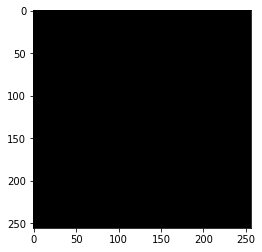

In [23]:
# draw all images in a merged image
merged_width = int(np.ceil(np.sqrt(no_of_images))*image_width)
merged_image = np.zeros((merged_width, merged_width, 3), dtype='uint8')

ellipside = True

for counter, index in enumerate(image_xindex_sorted):
    # set location
    if ellipside:
        a = np.ceil(reduced_transformed[counter, 0] * (merged_width-image_width-1)+1)
        b = np.ceil(reduced_transformed[counter, 1] * (merged_width-image_width-1)+1)
        a = int(a - np.mod(a-1,image_width) + 1)
        b = int(b - np.mod(b-1,image_width) + 1)
        if merged_image[a,b,0] != 0:
            continue
        image_address = image_names[counter]
        img = cv2.imread(image_address)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         _, img = cv2.threshold(img, 224, 255, cv2.THRESH_BINARY_INV)
        merged_image[a:a+image_width, b:b+image_width,:] = img[:,:,:3]
    else:
        b = int(np.mod(counter, np.sqrt(no_of_images)))
        a = int(np.mod(counter//np.sqrt(no_of_images), np.sqrt(no_of_images)))
        image_address = image_names[index]
        img = np.asarray(Image.open(image_address).resize((image_width, image_width)))
        merged_image[a*image_width:(a+1)*image_width, b*image_width:(b+1)*image_width,:] = img[:,:,:3]

plt.imshow(merged_image)
plt.show()
# merged_image = Image.fromarray(merged_image)
# if ellipside:
#     merged_image.save('merged-%s-ellipsoide-inception.png'%image_path.split('/')[-2])
# else:
#     merged_image.save('merged-%s.png'%image_path.split('/')[-2])

In [24]:
img = cv2.imread(image_names[0])

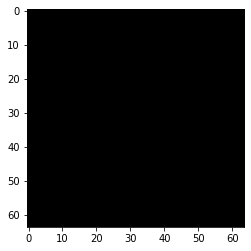

In [27]:
plt.imshow(img)
plt.show()